In [6]:
bar_kwargs = {'lw': 0, 'color': '#206090'}
line_kwargs = {'lw': 3, 'color': '#206090'}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from reduceddynamics import create_sequence, create_seq_data, plot_percepts, bigbox_world_generator

### Create data

All slots are independently set to 0 or 1 with probability $p$.
Set $p = 0.5$ for maximum Entropy. 

In [3]:
world_size = 20
box_size = 2
box_sep = 0
p = 0.5
window_size = 10
rng = np.random.RandomState(123)
sequence_length = 500
n_train = 10000
n_test = 10000

n_sequences = n_train + n_test

assert world_size >= window_size, 'Window must be at least as big as world.'

In [4]:
xs, ys = create_seq_data(bigbox_world_generator(world_size, box_size, box_sep, p * world_size / (box_size+box_sep), rng), 
                         window_size, 
                         sequence_length, 
                         n_sequences, 
                         rng, 
                         'int16')
x_train = xs[:n_train]
y_train = ys[:n_train]

x_test = xs[n_train:]
y_test = ys[n_train:]

#### Probability of one full turn (Monte Carlo) 

In [5]:
lengths = [10*k for k in xrange(10, 80)]
probs = []
for sequence_length in lengths:
    sample_n = 100
    pos = 0
    results = []
    for i in xrange(sample_n):
        visited = np.zeros(world_size, dtype='int16')
        for j in xrange(sequence_length):
            pos = (pos + (rng.randint(0, 2) * 2) - 1) % world_size
            visited[pos] = 1
        results.append(1 if np.sum(visited) == world_size else 0)
    probs.append(np.mean(results))

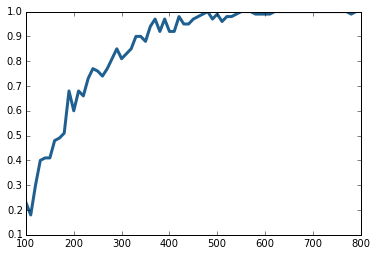

In [7]:
plt.plot(lengths, probs, **line_kwargs)
plt.show()

### Visualize data

In [370]:
b = 2
i = 8
print x_train[b, i, :-1]
print x_train[b, i, -1]
print y_train[b, i]

[0 0 0 0 0 0 0 0 1 1]
-1
[0 0 0 0 0 0 0 0 0 1]


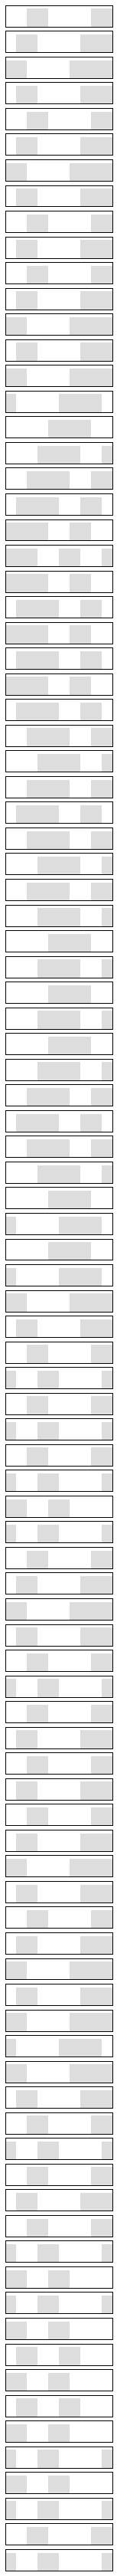

In [399]:
plot_percepts(np.array(ys[3, :100]), box_width=box_size)
pass

### Train recurrent network to learn dynamics 

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, TimeDistributedDense
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

In [9]:
n_hidden = 40

In [10]:
model = Sequential()
model.add(LSTM(output_dim=n_hidden, input_dim=window_size+1,
               return_sequences=True))
# model.add(LSTM(output_dim=percept_length, activation='tanh', inner_activation='hard_sigmoid',
#               return_sequences=True))
# model.add(TimeDistributedDense(output_dim=n_hidden, input_dim=window_size+1))
# model.add(Activation('sigmoid'))
model.add(TimeDistributedDense(window_size))
model.add(Activation('sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

/usr/local/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:135: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [12]:
model.fit(x_train, y_train, batch_size=4, nb_epoch=30,
          validation_split=0.1,
          callbacks=[early_stopping])

Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 413s - loss: 0.0037 - val_loss: 0.0031
Epoch 2/30
9000/9000 [==============================] - 121s - loss: 0.0026 - val_loss: 0.0022
Epoch 3/30
9000/9000 [==============================] - 119s - loss: 0.0019 - val_loss: 0.0015
Epoch 4/30
9000/9000 [==============================] - 118s - loss: 0.0013 - val_loss: 0.0011
Epoch 5/30
9000/9000 [==============================] - 116s - loss: 0.0011 - val_loss: 0.0011
Epoch 6/30
8016/9000 [=========================>....] - ETA: 12s - loss: 0.0009

KeyboardInterrupt: 

### Evaluate Model performance 

#### Error rate

We round the result to the nearest integer and consider the prediction to be erroneous if at least one slot is predicted incorrectly.

In [13]:
pred = model.predict(x_test)

In [14]:
overall_error_rate = np.mean(np.prod(np.round(1 - np.abs(pred - y_test)), axis=2))
position_error_rate = np.mean(np.abs(np.round(pred) - y_test))

In [15]:
print 'Overall error rate: {0}'.format(overall_error_rate)
print 'Position error rate: {0}'.format(position_error_rate)

Overall error rate: 0.990943
Position error rate: 0.0009057


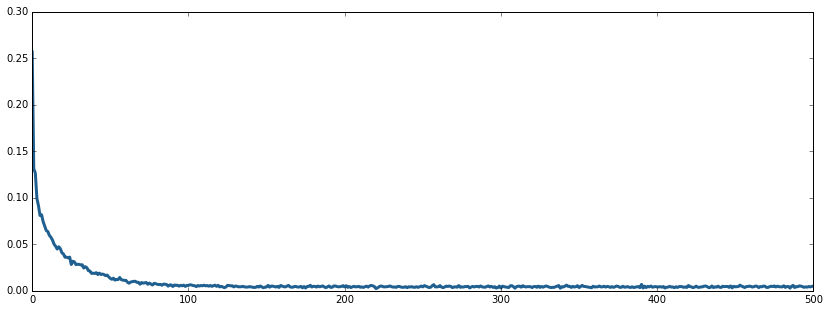

In [16]:
binary_errors = np.prod(np.round(1 - np.abs(pred - y_test)), axis=2)
binary_error_rate_wrt_time = 1 - np.mean(binary_errors, axis=0)

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111)
ax.plot(binary_error_rate_wrt_time, **line_kwargs)
# ax.fill_between(np.arange(len(binary_error_rate_wrt_time)), 
#                 0,
#                 binary_error_rate_wrt_time,
#                 color='#335599', 
#                 alpha=0.4)
plt.show()

In [21]:
print binary_error_rate_wrt_time[0]

0.2569


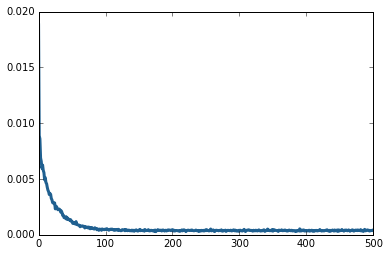

In [18]:
error_wrt_time = np.mean(np.mean((y_test - pred) ** 2, axis=0), axis=1)
plt.plot(error_wrt_time, **line_kwargs)
plt.show()

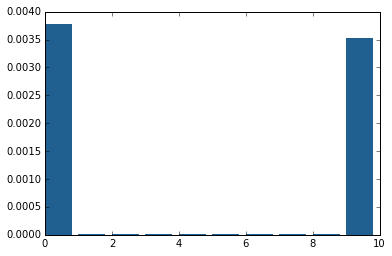

In [19]:
error_wrt_pos = np.mean(np.mean((y_test - pred) ** 2, axis=0), axis=0)
plt.bar(np.arange(len(error_wrt_pos)), error_wrt_pos, **bar_kwargs)
plt.show()

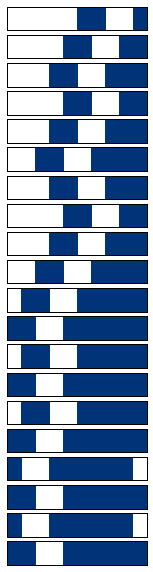

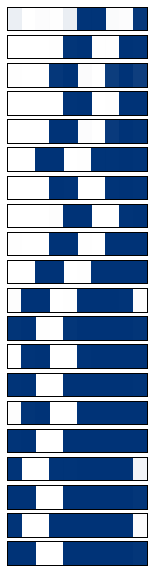

In [20]:
plot_percepts(y_test[3, :20], box_width=box_size)
plot_percepts(pred[3, :20], box_width=box_size)
pass